In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
lm = LinearRegression()
from sklearn import feature_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors

import statsmodels.api as sm

In [2]:
original_cancer = pd.read_csv("~/Downloads/cancer.csv")
cancer = pd.read_csv("~/Downloads/cancer.csv")

In [3]:
dummy_cancer = pd.get_dummies(data = cancer, drop_first=True) #adding dummy variables for categorical variable #region
print(dummy_cancer.columns)

Index(['avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate', 'medIncome',
       'povertyPercent', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize',
       'PercentMarried', 'PctPrivateCoverage', 'PctPublicCoverage',
       'BirthRate', 'region_Northeast', 'region_South', 'region_West'],
      dtype='object')


In [4]:
_X = dummy_cancer[['avgDeathsPerYear', 'incidenceRate', 'medIncome','povertyPercent', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize','PercentMarried', 'PctPrivateCoverage', 'PctPublicCoverage','BirthRate', 'region_Northeast', 'region_South','region_West']]
_y = dummy_cancer['TARGET_deathRate']

#Splitting data into training and test sets
#splitting training and Test data in 1:3 ratio

In [5]:
X_train_valid , X_test, y_train_valid, y_test = train_test_split(_X,_y, test_size = 0.25, random_state = 7283) 

# further diving data 2:1 split 

In [6]:
X_train, X_valid , y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 1/3, random_state = 7283)

In [7]:
X = cancer.copy()
del X['TARGET_deathRate']

**Model 1: Linear Regression**
We will start with model building followed by diagnosis

In [8]:
X_int = sm.add_constant(_X)
linreg = sm.OLS(_y, X_int).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     192.5
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:32:27   Log-Likelihood:                -13339.
No. Observations:                3017   AIC:                         2.671e+04
Df Residuals:                    3002   BIC:                         2.680e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                117.8969     11

Analysis 
- Rsq = 0.473
- Not significant values: povertyPercent, studyPerCap, AvgHouseholdSize, PercentMarried p-values greater than 0.05
- Negative Coefficients - AvgDeathsPerYear, medIncome, studyPerCap, MedianAge,PercentMarried, PctPrivateCoverage,BirthRate negatively affect the TargetDeathRate, i.e., the number of deaths caused decline by increase in values of these variables
- Positive coefficients incidenceRate, povertyPercent, AvgHouseholdSize, PctPublicCoverage are positive, i.e., Increase in value of these variables cause increase in death rate.
- Other parameters being the same, regions with highest death rate due to cancer is South, followerd by Midwest (baseline at 0), followed by Northeast and lastly West. 


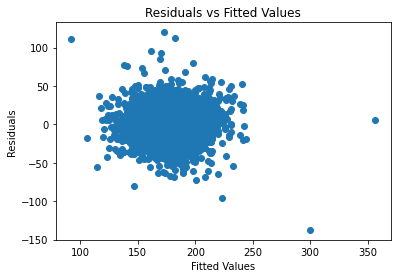

In [9]:
#Model Assessment 

plt.scatter(linreg.fittedvalues, linreg.resid) #Residual vs fitted value plot
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

The residual plot definitely looks like an evenly distributed blob with a few outliers. Since it is evenly distributed around the axis, linear Regression looks like a good model. However since our Rsq. values are pretty low & since the outliers are affecting the visualization, removing the outliers will give a better sense on the model.

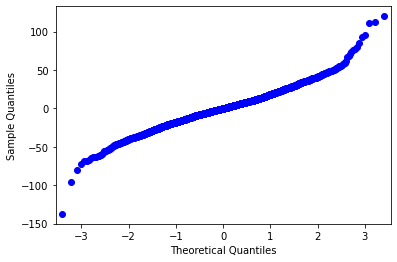

In [10]:
# QQ Plot
qqplot = sm.qqplot(linreg.resid)
plt.show()

Plot is not very linear with some deviations at the end which are pretty normal given we have observed the outliers in the earlier residual plot as well.

In [11]:
#C.Report MSE value on the test set. 

linreg = LinearRegression() #fitting LinearRegression model on training Data

linreg.fit(X_train_valid,y_train_valid)
y_test_pred = linreg.predict(X_test)
MSE_test = np.mean((y_test - y_test_pred)**2)

print("MSR for linear regression is ", MSE_test)

MSR for linear regression is  432.76152056446324


**Model 2 : Lasso**

In [12]:
# # #Scaling the data
scaler = StandardScaler() # Instantiate
scaler.fit(X_train) # Fit the data
X_train = pd.DataFrame(scaler.transform(X_train)) #transform X data
X_valid = pd.DataFrame(scaler.transform(X_valid))
X_train.columns = _X.columns.values
X_valid.columns = _X.columns.values

In [13]:
alphas = np.logspace(-10, 10, 21) #choosing range of 21 alpha values 

In [14]:
Validation_Scores = []
for a in alphas:
    lm_lasso = linear_model.Lasso(alpha=a)
    lm_lasso.fit(X_train, y_train) # Fit lasso model on training set
    Validation_Scores.append(metrics.mean_squared_error(lm_lasso.predict(X_valid), y_valid)) #Evaluating model on validation set


In [15]:
#Find minimum validation error and the corresponding lambda value
print("Min validation error for Lasso ", min(Validation_Scores))
minalpha = alphas[np.argmin(Validation_Scores)]
print("Min Alpha for Lasso", minalpha)

Min validation error for Lasso  471.526935815251
Min Alpha for Lasso 0.1


Lambda value = 0.1 and min testing_score (MSE) is 471.52
Test MSE for Lasso is a more than the MSE test for Regression. 

In [19]:
# # Refit model with train + validation set, perform prediction on test set
lm_lasso = linear_model.Lasso(alpha=minalpha)
lm_lasso.fit(X_train_valid, y_train_valid) # Fit model on training set
Validation_Scores_alpha = metrics.mean_squared_error(lm_lasso.predict(X_test), y_test)

print("Lasso validation score on test data", Validation_Scores_alpha)
print("Lasso coeffs")
print(pd.DataFrame(zip(lm_lasso.coef_, X_train_valid.columns.values)))

Lasso validation score on test data 430.62565484110905
Lasso coeffs
            0                   1
0   -1.586498    avgDeathsPerYear
1   12.158811       incidenceRate
2   -2.186583           medIncome
3    0.262742      povertyPercent
4   -0.361309         studyPerCap
5   -2.034080           MedianAge
6    0.537811    AvgHouseholdSize
7    0.045133      PercentMarried
8   -5.390100  PctPrivateCoverage
9    5.129991   PctPublicCoverage
10  -1.589250           BirthRate
11  -2.039298    region_Northeast
12   1.965294        region_South
13  -4.970248         region_West


Analysis:
MSE is 430 which is better than both the MSE values calculated above. So this is a good model fit for the data

- The coefficients for all variables has been normalised, esp for categorical dummy variables which had really high coeff. values. 
- Coeff for incidenceRate have increased significantly and stands out among all others. 
- Comparing with Linear Regression, the coefficients for 4 region dummy variables have pretty much the same interpretation. 



**Model 3 : Ridge** 

alphas = np.logspace(-10, 10, 21)

Valid_Scores = []
for a in alphas:
    lm_ridge = linear_model.Ridge(alpha=a)
    lm_ridge.fit(X_train, y_train) # Fit model on training set
    Valid_Scores.append(metrics.mean_squared_error(lm_ridge.predict(X_valid), y_valid)) # Evaluate model on validation set

In [21]:
# #Find minimum validation error and the corresponding lambda value
print("Min validation error for Ridge", min(Valid_Scores))
minalpha = alphas[np.argmin(Valid_Scores)]
print("Min Alpha for Ridge", minalpha)

Min validation error for Ridge 472.17814405830893
Min Alpha for Ridge 1.0


Analysis: 
Lambda value is 1.0 at lowest MSE value of 472.18

In [22]:
# Refit model with minalpha on train + validation set, perform prediction on test set
lm_ridge = linear_model.Ridge(alpha = minalpha)
lm_ridge.fit(X_train_valid, y_train_valid)
validation_score = metrics.mean_squared_error(lm_ridge.predict(X_test), y_test)
print("Ridge validation score on test data", validation_score)


Ridge validation score on test data 432.73983438873785


In [24]:
print("Ridge coeffs")
print(pd.DataFrame(zip(lm_ridge.coef_, X.columns.values))) #printing variable name and their coef values together


Ridge coeffs
            0                   1
0   -1.629726    avgDeathsPerYear
1   12.268700       incidenceRate
2   -2.135779           medIncome
3    0.351954      povertyPercent
4   -0.443876         studyPerCap
5   -2.487559           MedianAge
6    0.603828    AvgHouseholdSize
7    0.478853      PercentMarried
8   -5.320298  PctPrivateCoverage
9    5.537610   PctPublicCoverage
10  -1.780673           BirthRate
11  -2.110459              region


Analysis:
the coefficient values are very similar to the Lasso model and different from Linear Regression model above. While the variables with negative coefficients have been the same, the negative values have changed and are normalised. 
no variables have been dropped. 


**Model 4: KNN**

Creating a categorical response variable based on TARGET_deathRate. The number of groups K could be different.

In [25]:
dummy_cancer['tdr_category'] = np.array(pd.qcut(dummy_cancer['TARGET_deathRate'], q = [0, .33, .67, 1], labels = ['low','medium','high']))
print(dummy_cancer.groupby('tdr_category').size())

tdr_category
high       996
low        999
medium    1022
dtype: int64


In [26]:
_X = dummy_cancer[['avgDeathsPerYear', 'incidenceRate', 'medIncome','povertyPercent', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize','PercentMarried', 'PctPrivateCoverage', 'PctPublicCoverage','BirthRate', 'region_Northeast', 'region_South','region_West']]
_y = dummy_cancer['tdr_category']

In [27]:
# # # Splitting data into train_valid and test set 
X_train_valid , X_test, y_train_valid, y_test = train_test_split(_X,_y, test_size = 0.25, random_state = 7283) #splitting training and Test data in 1:3 ratio
# Further splitting the data into train and valid set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.37, random_state = 7283) #further splitting into train and validation


In [28]:
valid_misclf = []
for k in range(1, 11):
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    y_hat = knn.predict(X_valid)
    valid_misclf.append(np.mean(y_hat != y_valid))


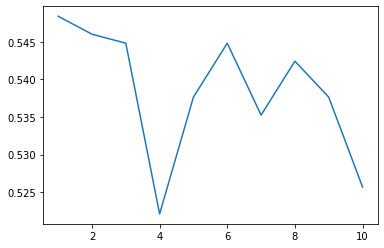

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1,11), valid_misclf)
plt.show()

In [31]:
bestK = np.argmin(valid_misclf) + 1
print('Best K value is ',bestK)
print('Misclassification is: ',valid_misclf[bestK-1])

Best K value is  4
Misclassification is:  0.5221027479091995


In [32]:
accuracy_score1 = knn.score(X_valid, y_valid)
print('Accuracy score of KNN is',accuracy_score1)

Accuracy score of KNN is 0.4743130227001195


As seen in the graph, for range (1, 11) the best K is 4 at misclassification of 40.86% which says that about 60% predictions are correct. Not a good number.
Train algorithm with the optimal K found above

In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors = bestK, weights = 'uniform')
knn.fit(X_train_valid, y_train_valid)
yhat = knn.predict(X_test)
misclf = np.mean(yhat != y_test)
# # print(misclf) 

accuracy_score2 = knn.score(X_test, y_test)
print(accuracy_score2)

0.49403973509933774
